In [1]:
from davitpy.models import *
from davitpy.pydarn.plotting import *
import davitpy.gme as gme
import datetime
import pandas
import numpy
from davitpy import utils
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import LinearLocator
import seaborn as sns
from pymongo import MongoClient
import sys
%matplotlib inline

In [8]:
plotCoords = "mag"
selTime = datetime.datetime( 2015, 1, 1, 3, 0 )
selTimeDstHigh = datetime.datetime( 2015, 1, 1, 3, 0 )
selTimeDstLow = datetime.datetime( 2015, 1, 1, 5, 30 )
sapsProbsFName = "../data/sapsProb-Models.txt"
# coords of collges
geoLatDrtmth = 43.7
geoLonDrtmth = -72.3
magLonDrtmth, magLatDrtmth = utils.coord_conv( geoLonDrtmth, geoLatDrtmth, \
                                 "geo", "mag", altitude=300., \
                                 date_time=selTime )
geoLatUMich = 42.27
geoLonUMich = -83.73
magLonUMich, magLatUMich = utils.coord_conv( geoLonUMich, geoLatUMich, \
                                 "geo", "mag", altitude=300., \
                                 date_time=selTime )
geoLatUWM = 43.07
geoLonUWM = -89.41
magLonUWM, magLatUWM = utils.coord_conv( geoLonUWM, geoLatUWM, \
                                 "geo", "mag", altitude=300., \
                                 date_time=selTime )
geoLatUMn = 44.97
geoLonUMn = -93.22
magLonUMn, magLatUMn = utils.coord_conv( geoLonUMn, geoLatUMn, \
                                 "geo", "mag", altitude=300., \
                                 date_time=selTime )

In [3]:
# Need a function to convert MLT to MLON
def convert_mlt_to_mlon(inpMLT, selTime=selTime):
    outMlon = None
    prevDiff = None
    for currMlon in range(0, 360):
        currMLT = aacgm.mltFromYmdhms(\
                          selTime.year, selTime.month,
                                    selTime.day, selTime.hour,
                                    selTime.minute, selTime.second,
                                    currMlon) 
        if abs(currMLT-inpMLT) < 0.1:
            if outMlon is None:
                outMlon = currMlon
                prevDiff = abs(currMLT-inpMLT)
            else:
                if prevDiff > abs(currMLT-inpMLT):
                    outMlon = currMlon
                    prevDiff = abs(currMLT-inpMLT)                
    return outMlon

def saps_pred_func(x, y, dst):    
    (a_sx, b_sx, a_sy, b_sy, a_xo, b_xo, a_yo, b_yo, a_o, b_o, theta) = \
        ( 3.04, 2.98e-03, 1.69,\
         -8.53e-04, 4.61, 6.36e-02, -1.28, 3.1e-02,
         8.49e-01, -1.57e-03, 6.69e-01)        
    sigma_x = a_sx + b_sx * dst
    sigma_y = a_sy + b_sy * dst
    xo = a_xo + b_xo * dst
    yo = a_yo + b_yo * dst
    amplitude = a_o + b_o * dst    
    
    a = (numpy.cos(theta)**2)/(2*sigma_x**2) + (numpy.sin(theta)**2)/(2*sigma_y**2)
    b = -(numpy.sin(2*theta))/(4*sigma_x**2) + (numpy.sin(2*theta))/(4*sigma_y**2)
    c = (numpy.sin(theta)**2)/(2*sigma_x**2) + (numpy.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*numpy.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g

In [4]:
# read SAPS model data
sapsModelDF = pandas.read_csv(sapsProbsFName, sep=' ')
sapsModelDF["pred_Mlon"] = [ convert_mlt_to_mlon(x) for x in sapsModelDF["pred_MLT"] ]
sapsModelDF.head()
sapsModelDF = sapsModelDF[ sapsModelDF["pred_prob"] >= 0.2 ].reset_index(drop=True)
latCntr, lonCntr = numpy.meshgrid( sapsModelDF["pred_Lat"],\
                                            sapsModelDF["pred_Mlon"] )
probCntr = numpy.zeros( latCntr.shape )
for i1 in range( probCntr.shape[0] ):
    for i2 in range( probCntr.shape[1] ):
        currProbList = sapsModelDF[ (sapsModelDF["pred_Lat"] == latCntr[i1][i2]) & \
                                       (sapsModelDF["pred_Mlon"] == lonCntr[i1][i2]) ]["pred_prob"].tolist()
        if len(currProbList) > 0:
            probCntr[i1][i2] = currProbList[0]
        else:
            probCntr[i1][i2] = numpy.nan

In [5]:
sapsPredDF = pandas.DataFrame(columns=["normMLT", "normLAT", "probSAPS", "MLT", "Lat", "dst_index"])
latArr = []
mltArr = []
normLatArr = []
normMltArr = []
probSapsArr = []
dstValArr = []
dstBinArr = []

dstValsInpList = [ -10., -100. ]

for z in range( len( dstValsInpList ) ):
    for x in range( 45, 70 ):
        for y in range( 0, 24 ):        
            normLatArr.append( x - 57.5 )
            mltArr.append( y )
            if y < 12:
                currNormMLT = y
            else:
                currNormMLT = y - 24.
            normMltArr.append( currNormMLT )
            latArr.append( x  )
            currDstVal = dstValsInpList[z]
            currProbVal = saps_pred_func(x-57.5, currNormMLT, currDstVal)
            if currProbVal > 0.001:
                probSapsArr.append( currProbVal )
            else:
                probSapsArr.append( 0. )
            dstValArr.append(currDstVal)
        
sapsPredDF["pred_MLT"] = mltArr
sapsPredDF["pred_Lat"] = latArr
sapsPredDF["normMLT"] = normMltArr
sapsPredDF["normLAT"] = normLatArr
sapsPredDF["probSAPS"] = probSapsArr
sapsPredDF["dst_index"] = dstValArr
print sapsPredDF.head()
# Dst High
sapsPredDFDstHigh = sapsPredDF[ sapsPredDF["dst_index"] == dstValsInpList[1] ]
sapsPredDFDstHigh["pred_Mlon"] = [ convert_mlt_to_mlon(x, selTime=selTimeDstHigh)\
                                for x in sapsPredDFDstHigh["pred_MLT"] ]
latCntrDstHigh, lonCntrDstHigh = numpy.meshgrid( sapsPredDFDstHigh["pred_Lat"],\
                                            sapsPredDFDstHigh["pred_Mlon"] )
probCntrDstHigh = numpy.zeros( latCntrDstHigh.shape )
print latCntrDstHigh.shape
for i1 in range( probCntrDstHigh.shape[0] ):
    for i2 in range( probCntrDstHigh.shape[1] ):
        currProbList = sapsPredDFDstHigh[ (sapsPredDFDstHigh["pred_Lat"] == latCntrDstHigh[i1][i2]) & \
                                       (sapsPredDFDstHigh["pred_Mlon"] == lonCntrDstHigh[i1][i2]) ]["probSAPS"].tolist()
        
        if len(currProbList) > 0:
            probCntrDstHigh[i1][i2] = currProbList[0]
        else:
            probCntrDstHigh[i1][i2] = numpy.nan#None#numpy.nan
            
print probCntrDstHigh
# Dst Low
sapsPredDFDstLow = sapsPredDF[ sapsPredDF["dst_index"] == dstValsInpList[0] ]
print "1111"
sapsPredDFDstLow["pred_Mlon"] = [ convert_mlt_to_mlon(x, selTime=selTimeDstLow)\
                                for x in sapsPredDFDstLow["pred_MLT"] ]
latCntrDstLow, lonCntrDstLow = numpy.meshgrid( sapsPredDFDstLow["pred_Lat"],\
                                            sapsPredDFDstLow["pred_Mlon"] )
print "2222"
probCntrDstLow = numpy.zeros( latCntrDstLow.shape )
print "3333"
for i1 in range( probCntrDstLow.shape[0] ):
    for i2 in range( probCntrDstLow.shape[1] ):
        currProbList = sapsPredDFDstLow[ (sapsPredDFDstLow["pred_Lat"] == latCntrDstLow[i1][i2]) & \
                                       (sapsPredDFDstLow["pred_Mlon"] == lonCntrDstLow[i1][i2]) ]["probSAPS"].tolist()
        
        if len(currProbList) > 0:
            probCntrDstLow[i1][i2] = currProbList[0]
        else:
            probCntrDstLow[i1][i2] = numpy.nan#None#numpy.nan
print "4444"            
print probCntrDstLow

   normMLT  normLAT  probSAPS  MLT  Lat  dst_index  pred_MLT  pred_Lat
0      0.0    -12.5       0.0  NaN  NaN      -10.0         0        45
1      1.0    -12.5       0.0  NaN  NaN      -10.0         1        45
2      2.0    -12.5       0.0  NaN  NaN      -10.0         2        45
3      3.0    -12.5       0.0  NaN  NaN      -10.0         3        45
4      4.0    -12.5       0.0  NaN  NaN      -10.0         4        45
(600, 600)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
1111
2222
3333


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


4444
[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.00760498  0.00760498
   0.00760498]
 [ 0.          0.          0.         ...,  0.00404088  0.00404088
   0.00404088]
 [ 0.          0.          0.         ...,  0.00166259  0.00166259
   0.00166259]]


In [6]:
# READ MHO coords from DB and convert them to MAGN coords
SDDB = "sd-work9.ece.vt.edu:27017"
SDBREADUSER = "sd_dbread"
SDBREADPASS = "5d"
conn = MongoClient('mongodb://{}:{}@{}/{}'.format(SDBREADUSER,
                                                              SDBREADPASS,
                                                              SDDB,
                                                              "isr"))

dbConn = conn["isr"]
qIn = {'code': "mho"}
qRes = dbConn.info.find(qIn)
for el in qRes:
    magPosMHOLon, magPosMHOLat = utils.coord_conv( el['pos']['lon'], el['pos']['lat'], \
                                 "geo", "mag", altitude=300., \
                                 date_time=selTime )
    magFovMHOLon, magFovMHOLat = utils.coord_conv( el['fov']['lon'], el['fov']['lat'], \
                                 "geo", "mag", altitude=300., \
                                 date_time=selTime )

In [27]:
colNames = [ "name", "code", "glat", "glon", "ins", "model", "status", "RT_status", "data_avail" ]
chainLocDF = pandas.read_csv("../data/chain-stations.txt", delim_whitespace=True,\
                                    header=None, names=colNames)
# get MLAT and MLON
gLonArr = chainLocDF["glon"].values
gLatArr = chainLocDF["glat"].values
mlon, mlat = utils.coord_conv( gLonArr, gLatArr, \
                                 "geo", "mag", altitude=300., \
                                 date_time=selTime )
chainLocDF["mlon"] = mlon
chainLocDF["mlat"] = mlat
selStnDF = chainLocDF[ chainLocDF["mlat"] <= 65. ].reset_index(drop=True)
selStnDF.head()

,name,code,glat,glon,ins,model,status,RT_status,data_avail,mlon,mlat
0,Fort-McMurray,mcm,56.649535,248.779728,GISTM/GPS,PolaRxS,Active,Complete,Near-Real-time,-51.328552,64.857081
1,Ministik-Lake,edm,53.350818,247.026160,GISTM/GPS,PolaRxS,Active,Complete,Near-Real-time,-52.458750,61.394155


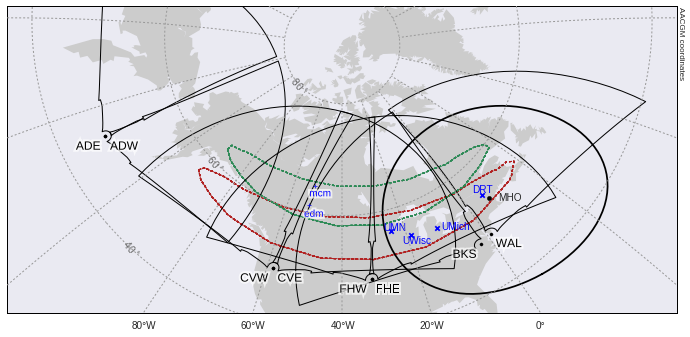

In [31]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
# set colorbar
seaMap = ListedColormap(sns.color_palette("Reds"))
# m1 = utils.plotUtils.mapObj(boundinglat=40., gridLabels=True,\
#                             coords=plotCoords, ax=ax, datetime=selTime)
m1 = utils.plotUtils.mapObj(lat_0=70., lon_0=-40, width=111e3*120,\
                      height=111e3*55, coords='mag', ax=ax, datetime=selTime)

codes = ['wal','fhe','fhw','cve','cvw','ade','adw','bks']
# Plotting some radars
overlayRadar(m1, fontSize=12, codes=codes)
# Plot radar fov
overlayFov(m1, codes=codes, maxGate=70)
# overlay MHO ISR
xPosMHO, yPosMHO = m1( magPosMHOLon, magPosMHOLat )
m1.scatter(xPosMHO, yPosMHO, zorder=6, s=20, facecolors='k')
m1.ax.text(xPosMHO * 1.02, yPosMHO * 0.98, "MHO", zorder=6)
xFovMHO, yFovMHO = m1( magFovMHOLon, magFovMHOLat )
m1.plot(xFovMHO, yFovMHO, 'k')
# Overlay Potential locations

xPosDrtmth, yPosDrtmth = m1( magLonDrtmth, magLatDrtmth )
m1.scatter(xPosDrtmth, yPosDrtmth, zorder=6, s=20, facecolors='b', marker="x")
m1.ax.text(xPosDrtmth * 0.98, yPosDrtmth * 1.02, "DRT", zorder=6, color="b")


xPosUMich, yPosUMich = m1( magLonUMich, magLatUMich )
m1.scatter(xPosUMich, yPosUMich, zorder=6, s=20, facecolors='b', marker="x")
m1.ax.text(xPosUMich * 1.01, yPosUMich * 0.98, "UMich", zorder=6, color="b")


xPosUWM, yPosUWM = m1( magLonUWM, magLatUWM )
m1.scatter(xPosUWM, yPosUWM, zorder=6, s=20, facecolors='b', marker="x")
m1.ax.text(xPosUWM * 0.98, yPosUWM * 0.9, "UWisc", zorder=6, color="b")


xPosUMn, yPosUMn = m1( magLonUMn, magLatUMn )
m1.scatter(xPosUMn, yPosUMn, zorder=6, s=20, facecolors='b', marker="x")
m1.ax.text(xPosUMn * 0.98, yPosUMn * 1.02, "UMN", zorder=6, color="b")



# Plot Chain stations
for index, row in selStnDF.iterrows():
    xVecGpsStn, yVecGpsStn = m1(row["mlon"], row["mlat"], coords="mag")
    m1.scatter( xVecGpsStn, yVecGpsStn, s=20., color="b", \
           alpha=0.7, zorder=5., edgecolor='none', marker="+", linewidth='1' )
    if row["mlat"] > 65.:
        yoff = 10
    else:
        yoff = -5
    utils.plotUtils.textHighlighted((xVecGpsStn, yVecGpsStn), row["code"], ax=ax,
                    xytext=(5, yoff), text_alignment=(0.5, 1),
                    variant='small-caps', fontsize=10,
                    zorder=6, color="b")







xCntrDstHigh, yCntrDstHigh = m1(lonCntrDstHigh, latCntrDstHigh, coords=plotCoords)
cntrPltDstHigh = m1.contour( xCntrDstHigh, yCntrDstHigh, probCntrDstHigh, 
            zorder = 2., levels=[0.25],
            colors = 'firebrick', linewidths=1.,linestyles='dotted' )



xCntrDstLow, yCntrDstLow = m1(lonCntrDstLow, latCntrDstLow, coords=plotCoords)
cntrPltDstLow = m1.contour( xCntrDstLow, yCntrDstLow, probCntrDstLow, 
            zorder = 2., levels=[0.25],
            colors = 'seagreen', linewidths=1.,linestyles='dotted' )


f.savefig("../figs/map-saps-gps.pdf",bbox_inches='tight')